In [167]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import random

import tensorflow as tf
print(tf.__version__)
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam

2.18.0


In [168]:
def rhs(t, z, L1, L2, m1, m2, g):

    """
    Computes the time derivatives (theta1_dot, w1_dot, theta2_dot, w2_dot) for a double pendulum.

    Parameters:

    t : float
        Current time (not used explicitly in this ODE but required by solve_ivp).
    z : array-like of float
        State vector [theta1, w1, theta2, w2].
    L1 : float
        Length of the first pendulum arm.
    L2 : float
        Length of the second pendulum arm.
    m1 : float
        Mass of the first bob.
    m2 : float
        Mass of the second bob.
    g : float
        Gravitational acceleration.

    Returns:

    (w1, w1dot, w2, w2dot) : tuple of float
        The derivatives of theta1, w1, theta2, w2 respectively.
    """

    theta1, w1, theta2, w2 = z
    cos12 = np.cos(theta1 - theta2)
    sin12 = np.sin(theta1 - theta2)
    sin1 = np.sin(theta1)
    sin2 = np.sin(theta2)
    xi = cos12**2*m2 - m1 - m2
    w1dot = ( L1*m2*cos12*sin12*w1**2 + L2*m2*sin12*w2**2
            - m2*g*cos12*sin2      + (m1 + m2)*g*sin1)/(L1*xi)
    w2dot = -( L2*m2*cos12*sin12*w2**2 + L1*(m1 + m2)*sin12*w1**2
            + (m1 + m2)*g*sin1*cos12  - (m1 + m2)*g*sin2 )/(L2*xi)

    return w1, w1dot, w2, w2dot


def to_cartesian(theta1, w1, theta2, w2, L1, L2):

    """
    Converts the angular positions and velocities of a double pendulum
    to Cartesian coordinates and velocities.

    Parameters:

    theta1 : array-like of float
        Angular displacement of the first pendulum (in radians) over time.
    w1 : array-like of float
        Angular velocity of the first pendulum over time.
    theta2 : array-like of float
        Angular displacement of the second pendulum (in radians) over time.
    w2 : array-like of float
        Angular velocity of the second pendulum over time.
    L1 : float
        Length of the first pendulum arm.
    L2 : float
        Length of the second pendulum arm.

    Returns:

    x1, y1, x2, y2, vx1, vy1, vx2, vy2 : tuple of arrays
        Cartesian coordinates (x1, y1) for the first bob, (x2, y2) for the second bob,
        and their corresponding velocities (vx1, vy1, vx2, vy2).
    """

    x1 = L1 * np.sin(theta1)
    y1 = -L1 * np.cos(theta1)
    x2 = x1 + L2 * np.sin(theta2)
    y2 = y1 - L2 * np.cos(theta2)
    vx1 = L1*np.cos(theta1)*w1
    vy1 = L1*np.sin(theta1)*w1
    vx2 = vx1 + L2*np.cos(theta2)*w2
    vy2 = vy1 + L2*np.sin(theta2)*w2
    return x1, y1, x2, y2, vx1, vy1, vx2, vy2


In [169]:
L1, L2 = 1., 1.
m1, m2 = 3., 1.
g = 9.81

z0=[np.pi/4,0,np.pi/4,0]

tmax, dt = 50, 0.1
t = np.arange(0, tmax + dt, dt)

k = 20
pred_ahead = 20

In [170]:
def create_dataset(data, k, pred_ahead):

    """
    Constructs a supervised-learning dataset for time-series prediction,
    using a sliding window of length k to predict the state at k-1 + pred_ahead.

    Parameters:

    data : array-like of shape (T, 4)
        Time-series data, typically (x1, y1, x2, y2) at each timestep.
    k : int
        Number of consecutive timesteps to use as input (the window size).
    pred_ahead : int
        How many steps beyond the window to predict.

    Returns:

    X : numpy.ndarray, shape (N, k, 4)
        Sequence of input windows.
    y : numpy.ndarray, shape (N, 4)
        Target positions at (k - 1 + pred_ahead).
    """

    X, y = [], []
    samples = len(data)
    for i in range(samples-k-pred_ahead):

        X_seq = data[i : i + k]
        target = data[i + k - 1 + pred_ahead]

        X.append(X_seq)
        y.append(target)

    return np.array(X), np.array(y)

In [171]:
def create_model():

    """
    Builds and compiles an LSTM-based model to predict (x1, y1, x2, y2).

    Returns:

    model : tensorflow.keras.Model
        A compiled LSTM model with output dimension 4, suitable for
        double-pendulum Cartesian coordinate prediction.
    """

    model = Sequential()
    model.add(LSTM(64, return_sequences=False, input_shape=(k, 4)))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(4))
    model.compile(optimizer=Adam(learning_rate=1e-3), loss='mse')

    return model

In [195]:
def plot_error_over_time(model, X_data, y_data, time_array, k, pred_ahead):
    """
    Plots the network's predictions of (x1, y1, x2, y2) vs. the true values
    in a 2x2 grid of subplots for each coordinate.

    Parameters:

    model : tensorflow.keras.Model
        Trained model that outputs (x1, y1, x2, y2).
    X_data : numpy.ndarray
        Sequence input (e.g., validation set) with shape (N, k, 4).
    y_data : numpy.ndarray
        True target values for (x1, y1, x2, y2), shape (N, 4).
    time_array : numpy.ndarray
        Time array used to align predictions with actual time steps.
    k : int
        Window size used to create X_data.
    pred_ahead : int
        How many steps into the future the model predicts from the end of the window.

    Returns:

        Displays a Matplotlib figure comparing predicted vs. true for
        x1(t), y1(t), x2(t), and y2(t).
    """

    y_pred = model.predict(X_data)

    indices = [i + (k - 1) + pred_ahead for i in range(len(X_data))]
    t_plot = time_array[indices]

    true_x1 = y_data[:, 0]
    true_y1 = y_data[:, 1]
    true_x2 = y_data[:, 2]
    true_y2 = y_data[:, 3]

    pred_x1 = y_pred[:, 0]
    pred_y1 = y_pred[:, 1]
    pred_x2 = y_pred[:, 2]
    pred_y2 = y_pred[:, 3]

    fig, ax = plt.subplots(2, 2, figsize=(12, 8), sharex=True)

    ax[0, 0].plot(t_plot, true_x1, 'b-', label='True x1')
    ax[0, 0].plot(t_plot, pred_x1, 'r--', label='Pred x1')
    ax[0, 0].set_title("Mass 1: x1 over time")
    ax[0, 0].set_ylabel("x1")
    ax[0, 0].legend()

    ax[0, 1].plot(t_plot, true_y1, 'b-', label='True y1')
    ax[0, 1].plot(t_plot, pred_y1, 'r--', label='Pred y1')
    ax[0, 1].set_title("Mass 1: y1 over time")
    ax[0, 1].legend()

    ax[1, 0].plot(t_plot, true_x2, 'b-', label='True x2')
    ax[1, 0].plot(t_plot, pred_x2, 'r--', label='Pred x2')
    ax[1, 0].set_title("Mass 2: x2 over time")
    ax[1, 0].set_xlabel("Time")
    ax[1, 0].set_ylabel("x2")
    ax[1, 0].legend()

    ax[1, 1].plot(t_plot, true_y2, 'b-', label='True y2')
    ax[1, 1].plot(t_plot, pred_y2, 'r--', label='Pred y2')
    ax[1, 1].set_title("Mass 2: y2 over time")
    ax[1, 1].set_xlabel("Time")
    ax[1, 1].legend()

    plt.tight_layout()
    plt.show()


In [173]:
def run_experiment_m1_m2(z0, k, pred_ahead, epochs=30):


    """
    Solves the ODE for a double pendulum with the given initial conditions,
    trains an LSTM to predict both masses' Cartesian coordinates
    (x1, y1, x2, y2) pred_ahead steps into the future, and plots error over time.

    Parameters:

    list or array of float
        Initial conditions [theta1, w1, theta2, w2].
    k : int
        Input sequence length for the LSTM.
    pred_ahead : int
        How many timesteps into the future to predict.
    epochs : int, optional
        Number of epochs for training (default = 30).

    Returns:

    model : tensorflow.keras.Model
        Trained Keras model for predicting (x1, y1, x2, y2).
    history : tensorflow.keras.callbacks.History
        Training history object containing loss and validation metrics.
    val_mse : float
        Final validation MSE after training.
    """

    t = np.arange(0, tmax + dt, dt)
    ret = solve_ivp(rhs, (0, tmax), z0, t_eval=t, args=(L1, L2, m1, m2, g))
    theta1, w1, theta2, w2 = ret.y

    x1, y1, x2, y2, vx1, vy1, vx2, vy2 = to_cartesian(theta1, w1, theta2, w2, L1, L2)
    data = np.column_stack((x1, y1, x2, y2))

    X, y = create_dataset(data, k, pred_ahead)
    print("X.shape =", X.shape, "y.shape =", y.shape)

    split_idx = int(0.8 * len(X))
    X_train, y_train = X[:split_idx], y[:split_idx]
    X_val,   y_val   = X[split_idx:], y[split_idx:]

    model = create_model()

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=30,
        batch_size=32,
        verbose=1
    )

    val_mse = model.evaluate(X_val, y_val, verbose=0)
    print(f"Validation MSE, pred_ahead={pred_ahead}:", val_mse)

    plot_error_over_time(model, X_val, y_val, t, k, pred_ahead)

    return model, history, val_mse, data


# **Discussion of the Predicted vs. True Plots**

1. **x‐Coordinates Predicted Better Than y**
- Small changes in theta result in significant variations of y‐coordinates for the double pendulum because they depend on the cos(theta) function. Small changes in angle lead to significant errors in y values.
- The x = sin(theta) displays less variability which results in smaller visible errors when the model misestimates angular values.

2. **Expected Shape of the Graphs vs. Reality**
- Both masses will exhibit oscillatory movements with x following a sinusoidal pattern and y demonstrating a more intricate but still oscillatory path.
- The real data plots show x as a smoother oscillatory pattern while y demonstrates sudden sharp changes in its peaks and valleys. The predicted curves align closely with these shapes but display a slight phase shift along the y coordinate.

3. **Overall Quality of the Predictions**
- The model accurately reproduces the primary pattern with particular success for x_1 and x_2.
- The y coordinates follow the basic oscillatory pattern but exhibit differences in both amplitude and phase.
- The network demonstrates clear learning of the fundamental motion principles of the double pendulum given this starting condition despite existing inconsistencies.

4. **Additional Observations**
- The y discrepancy expands over time when the system exhibits chaotic behavior. We can reduce this error by increasing training data volume or using a model with higher capacity or by decreasing the size of dt.
- The outstanding x correspondence proves that the model successfully captures each mass's primary frequency and amplitude during horizontal swings.



X.shape = (461, 20, 4) y.shape = (461, 4)
Epoch 1/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - loss: 0.6029 - val_loss: 0.2347
Epoch 2/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.2001 - val_loss: 0.0796
Epoch 3/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0663 - val_loss: 0.0428
Epoch 4/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0439 - val_loss: 0.0329
Epoch 5/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0325 - val_loss: 0.0269
Epoch 6/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0259 - val_loss: 0.0207
Epoch 7/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0203 - val_loss: 0.0171
Epoch 8/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0167 - val_loss: 0.0152
Epoch 9/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0147 - val_loss: 0.0144
Epoch 10/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0140 - val_loss: 0.0137
Epoch 11/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0135 - val_loss: 0.0132
Epoch 12/30
12/12 ━━━

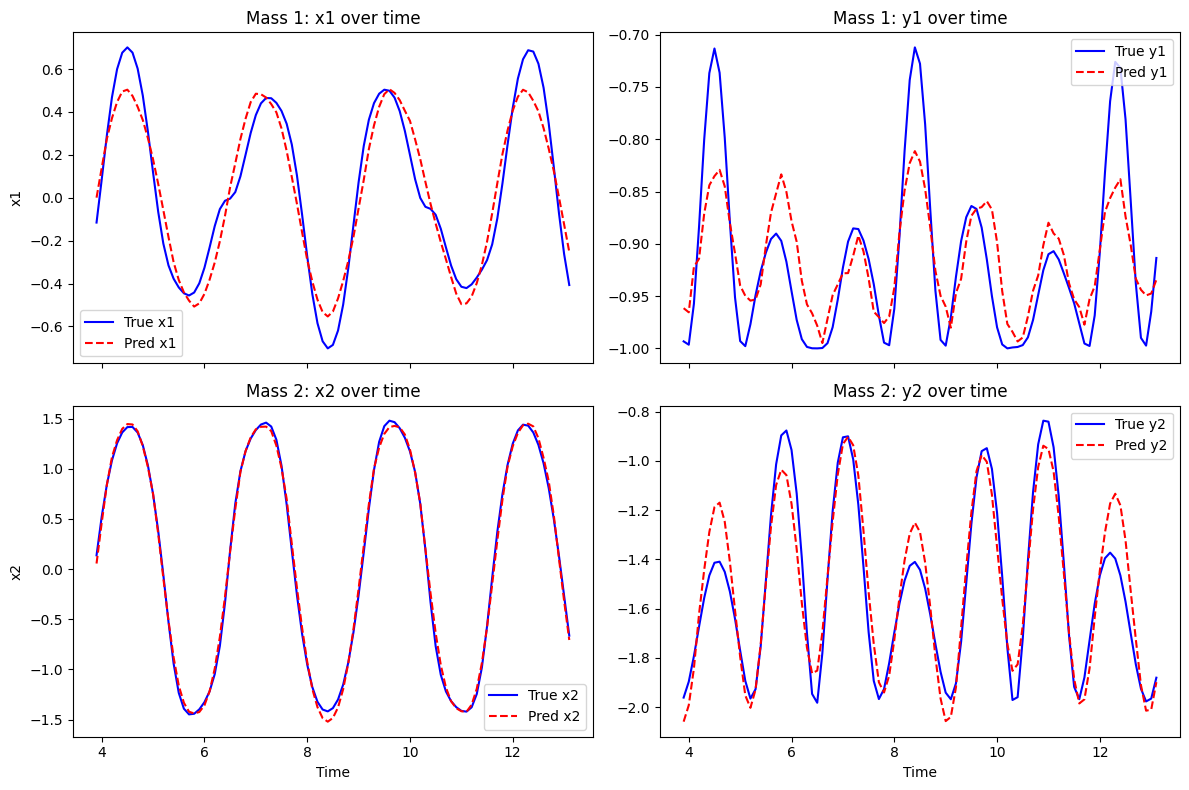

In [174]:
model, history, val_mse, data = run_experiment_m1_m2(z0, k, pred_ahead)

In [175]:
deltas = [0.02, 0.05]

def plot_pert_pend(deltas, k, pred_ahead):

    """
    Assesses the stability of the trained model to small perturbations
    in the initial angle of the double pendulum. Plots true vs. predicted
    trajectories for each perturbation.

    Parameters:

    deltas : list of float
        Small angle perturbations to apply to the initial condition's
        theta1 (e.g., [0.02, 0.05]).
    k : int
        Window size used in the model's training.
    pred_ahead : int
        Future timesteps the model is predicting.

    Returns:

    None
        Displays Matplotlib subplots comparing true and predicted
        (x1, y1, x2, y2) for each perturbation in deltas.
    """

    colors = plt.cm.viridis(np.linspace(0, 1, len(deltas)))

    fig, ax = plt.subplots(2, 2, figsize=(14, 10))

    for i, delta in enumerate(deltas):

        z0_pert = [z0[0] + delta, z0[1], z0[2] + delta, z0[3]]

        ret = solve_ivp(rhs, (0,tmax), z0_pert, t_eval=t, args=(L1, L2, m1, m2, g))
        z_pert=ret.y

        theta1_pert, w1_pert, theta2_pert, w2_pert = z_pert[0], z_pert[1], z_pert[2], z_pert[3]

        new_x1, new_y1, new_x2, new_y2, new_vx1, new_vy1, new_vx2, new_vy2 = to_cartesian(theta1_pert, w1_pert, theta2_pert, w2_pert, L1, L2)

        pert_data = np.column_stack((new_x1, new_y1, new_x2, new_y2))

        X_pert, y_pert = create_dataset(pert_data, k, pred_ahead)

        predictions = model.predict(X_pert)

        time_pred = t[k - 1 + pred_ahead : k - 1 + pred_ahead + len(predictions)]

        true_x1 = new_x1[k - 1 + pred_ahead : k - 1 + pred_ahead + len(predictions)]
        true_y1 = new_y1[k - 1 + pred_ahead : k - 1 + pred_ahead + len(predictions)]
        true_x2 = new_x2[k - 1 + pred_ahead : k - 1 + pred_ahead + len(predictions)]
        true_y2 = new_y2[k - 1 + pred_ahead : k - 1 + pred_ahead + len(predictions)]

        col = colors[i]

        ax[0, 0].plot(time_pred, true_x1, color=col, linestyle='-', linewidth=2,
                      label=f"True, δ={delta}")
        ax[0, 0].plot(time_pred, predictions[:, 0], color='green', linestyle='-',
                      linewidth=1, alpha=0.7, label="Predicted" if i==0 else None)

        ax[0, 1].plot(time_pred, true_y1, color=col, linestyle= '-', linewidth=2,
                      label=f"True, δ={delta}")
        ax[0, 1].plot(time_pred, predictions[:, 1], color='green', linestyle= '-',
                      linewidth=1, alpha=0.7, label="Predicted" if i==0 else None)

        ax[1, 0].plot(time_pred, true_x2, color=col, linestyle= '-', linewidth=2,
                      label=f"True, δ={delta}")
        ax[1, 0].plot(time_pred, predictions[:, 2], color='green', linestyle= '-',
                      linewidth=1, alpha=0.7, label="Predicted" if i==0 else None)

        ax[1, 1].plot(time_pred, true_y2, color=col, linestyle= '-', linewidth=2,
                      label=f"True, δ={delta}")
        ax[1, 1].plot(time_pred, predictions[:, 3], color='green', linestyle= '-',
                      linewidth=1, alpha=0.7, label="Predicted" if i==0 else None)

    titles = [
        "Mass 1: x vs time",
        "Mass 1: y vs time",
        "Mass 2: x vs time",
        "Mass 2: y vs time"
    ]

    for ax_i, title in zip(ax.flat, titles):
        ax_i.set_title(f"{title} (Bold: True, Thin: Predicted)")
        ax_i.set_xlabel("Time")
        ax_i.set_ylabel(title.split(':')[1].split()[0])  # e.g., "x" or "y"
        ax_i.legend()

    plt.tight_layout()
    plt.show()

# **Observations on the Perturbed Plots**

- **Effect of Perturbations delta:**  
  Each subplot overlays two true trajectories purple and yellow lines at delta=0.02 and delta=0.05 onto a single predicted trajectory green line. Even small differences in the initial angle cause visibly different pendulum paths, illustrating the system’s chaotic nature.

- **Consistency for x-Coordinates:**  
  In both masses’ x‐plots top‐left and bottom‐left, the network’s predicted line green follows very closely the true lines purple and yellow, even though those true lines are slightly shifted from each other. This suggests the model’s short‐term predictions remain robust in the horizontal direction despite small deviations in the initial state.

- **Greater Divergence in y:**  
  For the y‐coordinates top‐right and bottom‐right, the predicted trajectory occasionally drifts between the two true curves. The model is capturing the main oscillatory pattern but, as we see, vertical motions are more sensitive: small angle changes cause bigger amplitude or phase changes in y.

- **Chaotic Sensitivity:**  
  As delta increases from 0.02 to 0.05, notice how the purple and yellow curves the two true paths diverge more from each other over time. This is a hallmark of chaotic systems, where tiny initial differences can grow larger with each oscillation.

- **Overall Model Performance:**  
  Despite these perturbations, the single predicted line trained from the nominal initial condition tracks the general oscillations well. The difference is more pronounced in y, but it stays relatively close to each true path for many cycles. This implies the network has learned the core oscillatory dynamics, though exact matching in a chaotic regime is naturally difficult.

- **Key Takeaway:**  
  These plots confirm the double pendulum’s sensitive dependence on initial conditions: the true trajectories split apart for small delta, yet the model retains a similar shape. The mismatch is more visible in y, reflecting how vertical motion can magnify small phase differences or amplitude offsets.


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


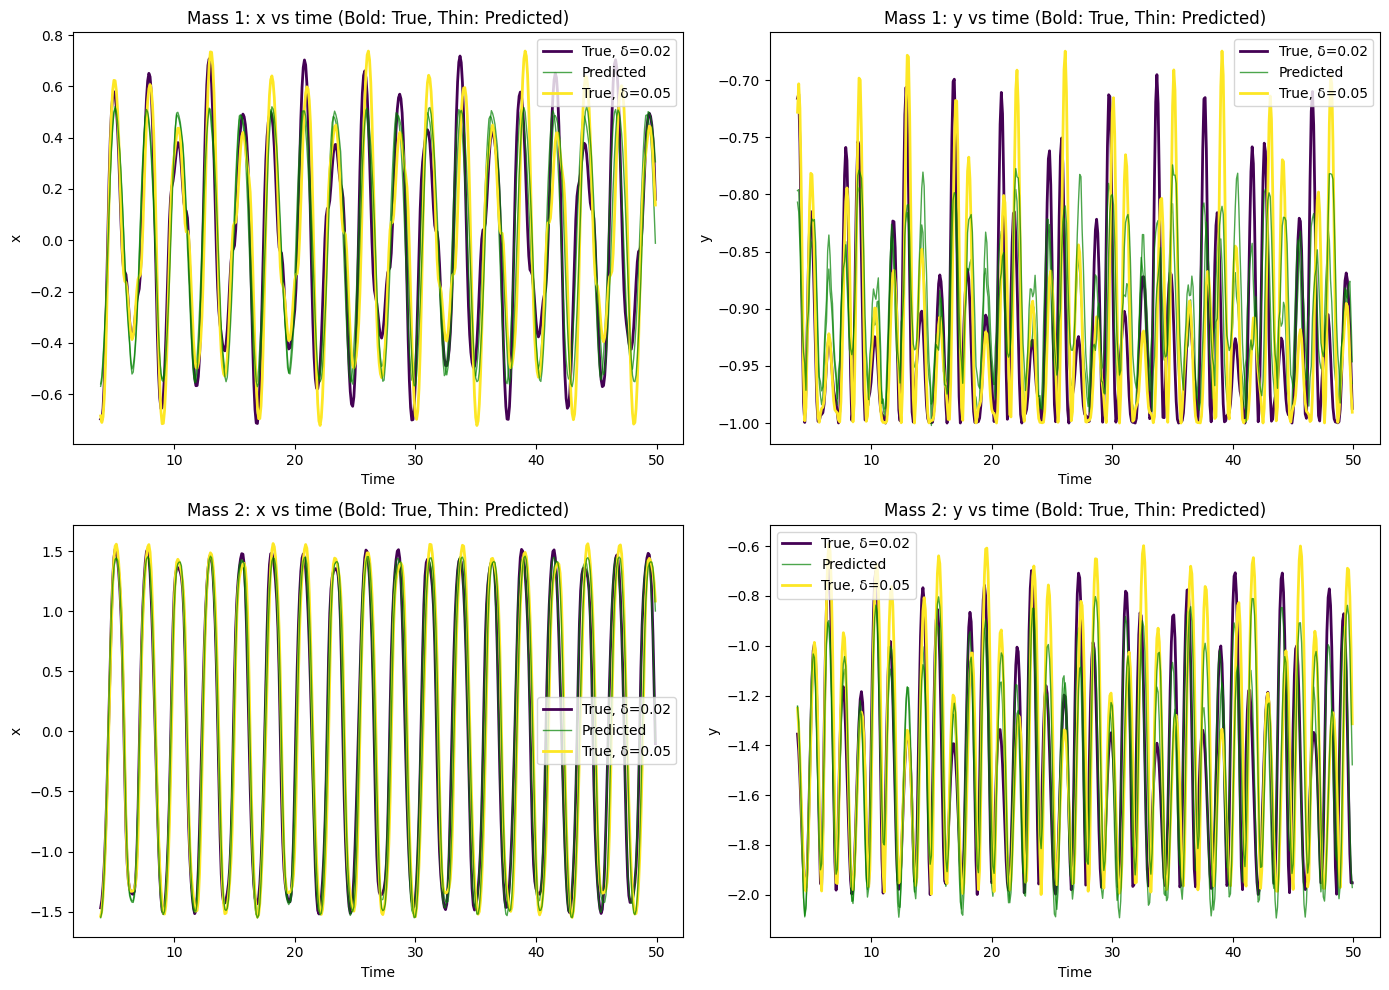

In [176]:
plot_pert_pend(deltas, k, pred_ahead)

In [177]:
prediction_values = [20, 40, 60, 80, 100]

def prediction_err_plot(prediction_values, k):

    """
    Trains and evaluates the model for multiple 'pred_ahead' settings,
    measuring how prediction error changes as we forecast farther
    into the future.

    Parameters:

    prediction_values : list of int
        Future forecast horizons (e.g., [20, 40, 60, 80, 100]) in timesteps.
    k : int
        Window size used for create_dataset().

    Returns:

        Displays a Matplotlib plot of validation MSE vs. 'pred_ahead' values.
    """

    errors = []

    for pred_ahead in prediction_values:
        model = create_model()

        X, y = create_dataset(data, k, pred_ahead)

        split_idx = int(0.8 * len(X))
        X_train, y_train = X[:split_idx], y[:split_idx]
        X_val,   y_val   = X[split_idx:], y[split_idx:]

        history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=30, batch_size=32, verbose=0)

        val_mse = model.evaluate(X_val, y_val, verbose=0)
        errors.append(val_mse)

    plt.figure(figsize=(8, 5))
    plt.plot(prediction_values, errors, marker='o', linestyle='-')
    plt.title("Prediction Error vs. Prediction values")
    plt.xlabel("Future timesteps")
    plt.ylabel("Validation MSE")
    plt.grid()
    plt.show()

# **Observations on the MSE vs. Prediction Horizon**

- **Non‐Monotonic Trend**  
  Instead of steadily rising with longer horizons which might be expected for a chaotic system, the curve shows peaks and drops at specific points e.g., it dips around 40 steps, then rises, then drops again near 100 steps.  

- **Variability Due to Re‐Training**  
  Each point on the plot represents a separate model training run, potentially converging to different local minima in the loss landscape. As a result, the final validation MSE can vary in non‐intuitive ways—even lower MSE at 100 steps compared to 20 steps is possible if a particular run lucked into a better solution.

- **Chaotic Sensitivity vs. Model Fitting**  
  While wit is typically expected for larger horizons like 80 or 100 steps to be more difficult, the network might occasionally capture core oscillations well enough—or the random initialization/training conditions might favor the longer horizon case. The relatively small differences in MSE here ~0.005–0.007 suggest these models are all performing similarly in an absolute sense.

- **Caution Interpreting “Sudden Drops”**  
  A very low MSE at 100 steps can be misleading. It may imply that, on that training run, the model latched onto a stable pattern, or simply that random seeding yielded a more optimal fit for the given data split. If it re‐ran the experiment multiple times, it might display a different distribution of MSEs.

- **Key Takeaway**  
  Although it is anticipated, a general trend of longer horizon to higher error, these results highlight the inherent run‐to‐run variance when training neural networks for chaotic sequences. Additional runs, or using an ensemble of models, can provide a more robust sense of the average difficulty at each horizon.


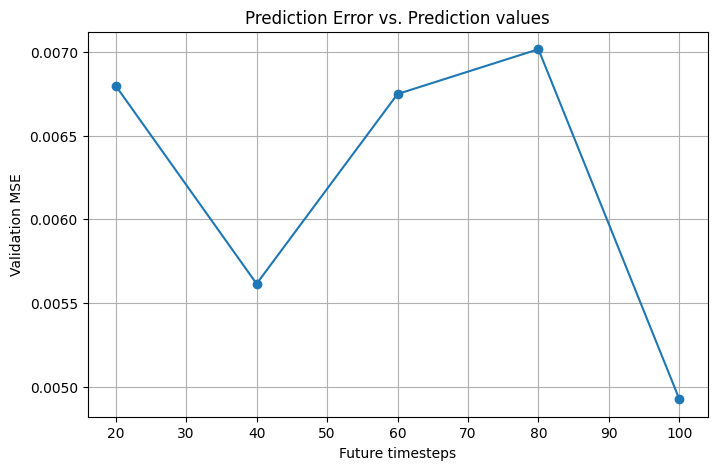

In [178]:
prediction_err_plot(prediction_values, k)

# **Observations for z_0 = [pi/2, 0, pi/2, 0] vs. the pi/4 Run**

1. **Greater Complexity in the Motion**  
   - With angles starting at theta_1 = theta_2 = pi/2, the system exhibits larger amplitude swings and more rapid changes, as evidenced by the more peaky plots in both x and y.  
   - Compared to the pi/4 initial condition which had cleaner, near‐sinusoidal oscillations, these trajectories look more varied, indicating a more complex region of the double‐pendulum state space.

2. **Prediction Mismatch and Phase Shifts**  
   - In both masses, the predicted red, dashed lines deviate more noticeably from the true blue ones.  
   - it can be seen that the model is struggling to align peaks and troughs, particularly in the y coordinate. This is characteristic of the chaotic nature of the double pendulum when started from a higher energy configuration pi/2 angles.

3. **Overall Error**  
   - The validation MSE is still on the same order of magnitude but somewhat larger than the pi/4 run’s best cases here it’s ~0.44. This matches the intuition that more complex initial conditions yield harder trajectories to predict consistently.  
   - The model still captures the general pattern oscillation frequency, rough amplitude, but errors accumulate faster in both amplitude and phase.

4. **Comparison to the pi/4 Case**  
   - The pi/4 initial condition had more regular swinging behavior, making it somewhat easier for the LSTM to learn and predict.  
   - Now, with pi/2, the system’s motion is more extreme, leading to increased or earlier divergence between true and predicted paths.

5. **Key Takeaway**  
   - Higher initial angles and thus higher energy push the double pendulum into a more chaotic regime.  
   - The RNN can still approximate the motion’s rough shape but shows more noticeable phase offsets and amplitude differences.  
   - This confirms the system’s sensitivity and the increased difficulty in modeling high‐energy initial states.


X.shape = (461, 20, 4) y.shape = (461, 4)
Epoch 1/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 0.6837 - val_loss: 0.4388
Epoch 2/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.5011 - val_loss: 0.3243
Epoch 3/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.4000 - val_loss: 0.3325
Epoch 4/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.3784 - val_loss: 0.3237
Epoch 5/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.3560 - val_loss: 0.3240
Epoch 6/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.3382 - val_loss: 0.3355
Epoch 7/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.3239 - val_loss: 0.3472
Epoch 8/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.3071 - val_loss: 0.3688
Epoch 9/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.2874 - val_loss: 0.3871
Epoch 10/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.2702 - val_loss: 0.3988
Epoch 11/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.2561 - val_loss: 0.4057
Epoch 12/30
12/12 ━━━

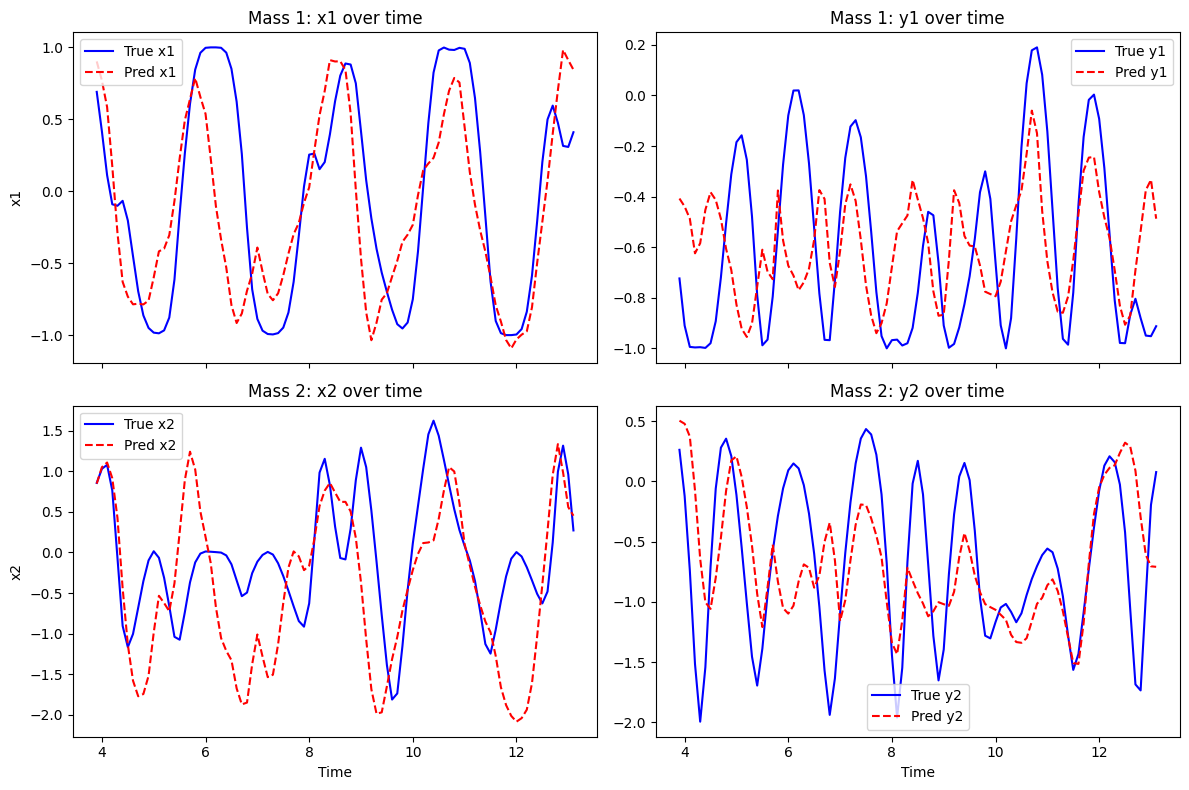

In [179]:
z0 = [np.pi/2, 0, np.pi/2, 0]

model, history, val_mse, data = run_experiment_m1_m2(z0, k, pred_ahead)

# **Observations for z_0 = pi/2 and Perturbations delta = 0.02, 0.05**

- **More Irregular Motion**  
  Compared to the pi/4 case, these plots show larger swings and more chaotic oscillations for both masses. Small perturbations at higher energy levels produce visibly different trajectories, underlining the sensitive nature of the system.

- **Greater Spread in x and y**  
  In the pi/4 run, all lines clustered closely around a simpler sinusoidal shape. Here, the purple and yellow lines true trajectories vary more widely from each other, and the predicted curve in green sometimes veers between them. This indicates the model struggles to reconcile the chaotic divergence in both masses.

- **Phase and Amplitude Mismatches**  
  In the y-coordinate especially, the predicted signal can fall behind or lead the true signals, showing how small errors in angle or velocity amplify more intensely in the vertical direction. The predicted x coordinate also deviates more severely than before, reflecting the higher complexity of the initial state.

- **Comparison to pi/4**  
  At pi/4, the oscillations were neater, so the network could maintain a closer fit for each perturbation. With pi/2, there are many rapid peaks and troughs, so even small initial changes lead to broader differences. The model’s single predicted line cannot track both perturbed paths as well, resulting in more visible discrepancies.

- **Conclusion**  
  This higher-energy scenario starting at pi/2 intensifies the pendulum’s chaotic sensitivity, which the model can only approximate. The network still captures a general oscillatory pattern, but we see increased divergence and phase shifts, highlighting the challenge of predicting chaotic dynamics under perturbed initial conditions.


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


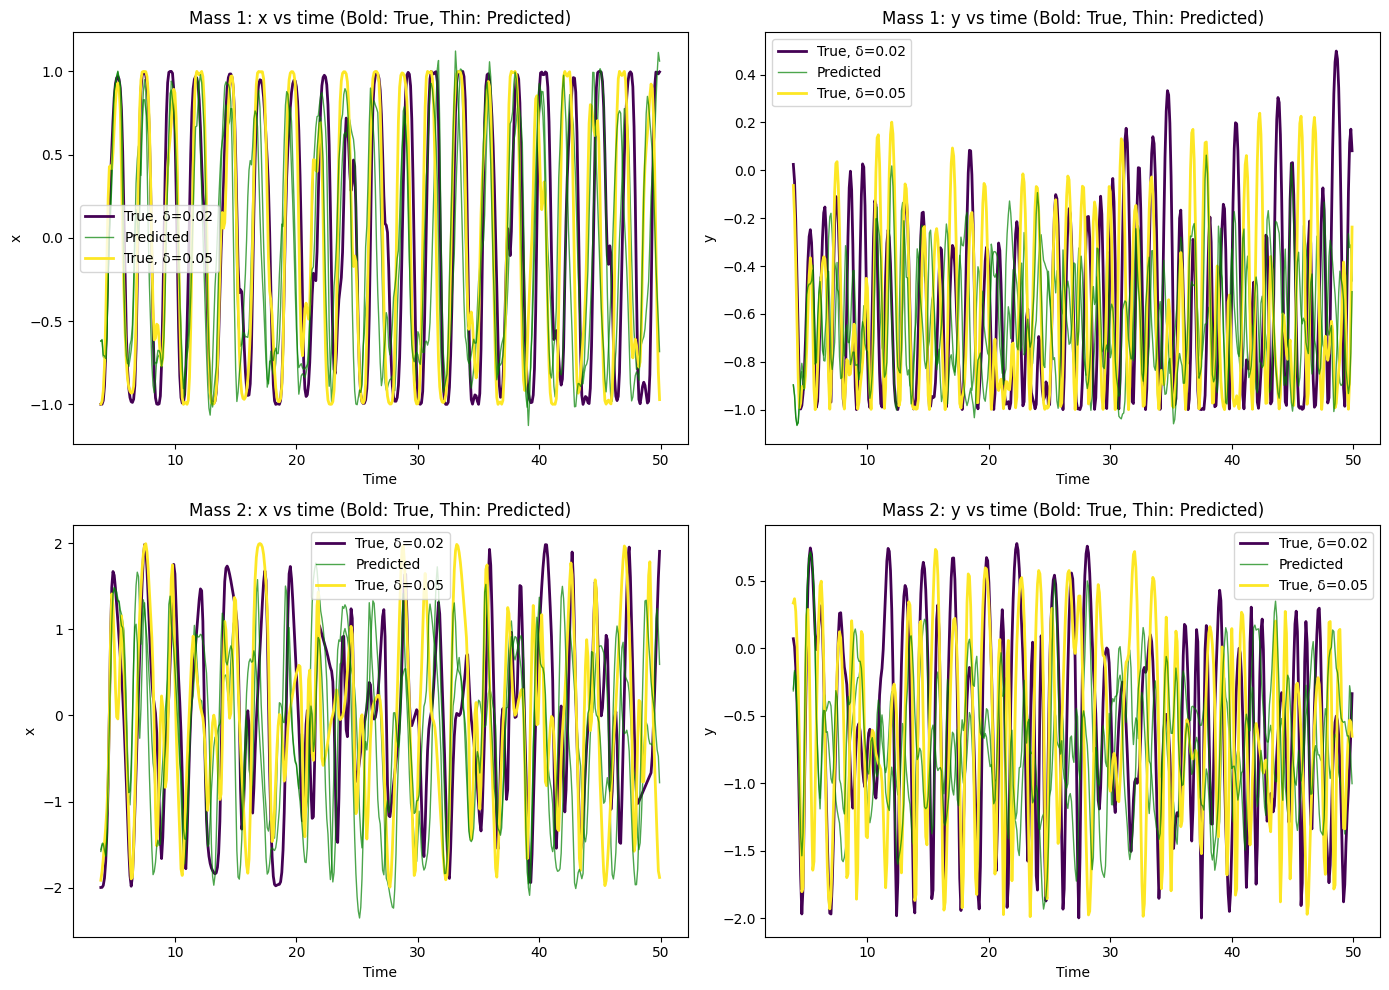

In [180]:
deltas = [0.02, 0.05]

plot_pert_pend(deltas, k, pred_ahead)

# **Observations on the MSE vs. Prediction Horizon pi/2 Initial Condition**

- **Overall Upward Drift**  
  We see the validation MSE generally increasing as the prediction horizon extends 40 to 60 steps. This matches the typical expectation that predicting further into the future for a chaotic system becomes more difficult.

- **Non‐Monotonic Behavior**  
  Notice the dip around 80 steps, where the MSE briefly lowers before rising again by 100 steps. This can happen if the model at 80 steps happens to converge to a more favorable local minimum than it does for other horizons, or due to subtle differences in how the data splits and random initializations occur for each experiment.

- **Comparison to pi/4 Case**  
  In the simpler pi/4 initial condition, we sometimes saw smaller MSE values for short horizons. For pi/2, the baseline errors even at 20 steps are higher than many of the earlier runs, indicating the model struggles more with high‐energy initial states.

- **Key Takeaway**  
  While chaotic systems usually yield increasing errors at larger horizons, re‐training for each horizon can produce occasional dips. Overall, the network’s performance is consistently worse for this more energetic initial condition compared to lower‐angle scenarios, which underscores the challenge of long‐term forecasting in chaotic regimes.


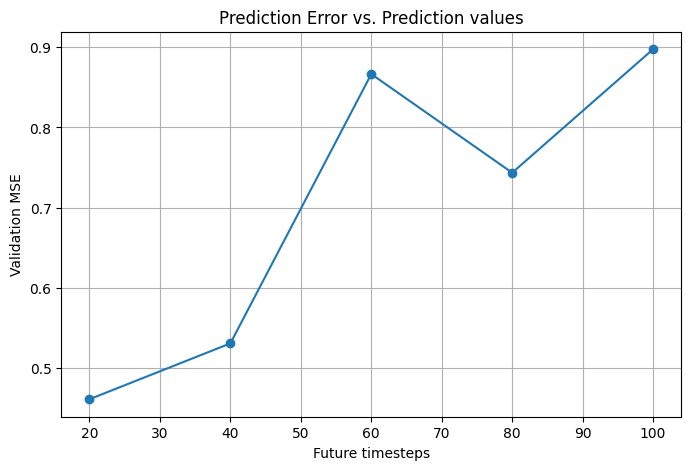

In [181]:
prediction_err_plot(prediction_values, k)

In [182]:
# Set up the initial conditions. Here we have lengths and masses
L1, L2 = 1., 1.
m1, m2 = 3., 1.
g = 9.81     # [m/s^2]. Gravitational acceleration

#Starting angles
z0=[np.pi/4,0,np.pi/4,0]

#Time ranges
tmax, dt = 50, 0.1

k = 20
pred_ahead = 20

In [183]:
def create_dataset_m2(data, k, pred_ahead):

    """
    Constructs a time-series dataset for predicting the Cartesian coordinates
    of only the second mass (x2, y2).

    Parameters:

    data : array-like of shape (T, 2)
        Time-series data of the second mass, (x2, y2) at each timestep.
    k : int
        Number of consecutive timesteps used as input.
    pred_ahead : int
        How many steps beyond the input window to predict.

    Returns:

    X : numpy.ndarray, shape (N, k, 2)
        Windowed input sequences.
    y : numpy.ndarray, shape (N, 2)
        Target positions at (k - 1 + pred_ahead).
    """

    X, y = [], []

    for i in range(len(data) - k - pred_ahead):

        X_seq = data[i : i + k]
        target = data[i + k - 1 + pred_ahead]

        X.append(X_seq)
        y.append(target)

    return np.array(X), np.array(y)

In [184]:
def create_model_m2(k):

    """
    Builds and compiles an LSTM-based model for predicting only (x2, y2).

    Parameters:

    k : int
        Input sequence length for the LSTM layer.

    Returns:

    model : tensorflow.keras.Model
        A compiled LSTM model whose output dimension is 2,
        intended to predict the second mass's coordinates (x2, y2).
    """

    model = Sequential()
    model.add(LSTM(64, input_shape=(k, 2), return_sequences=False))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(2))
    model.compile(optimizer=Adam(1e-3), loss='mse')
    return model

In [185]:
def plot_prediction_vs_true_m2(model, X_data, y_data, time_array, k, pred_ahead):

    """
    Plots predicted (x2, y2) vs. true (x2, y2) for a trained model,
    to visually inspect accuracy over time.

    Parameters:

    model : tensorflow.keras.Model
        Trained Keras model for mass m2 only.
    X_data : numpy.ndarray
        Windowed input sequences for validation or testing.
    y_data : numpy.ndarray
        True target values for (x2, y2).
    time_array : numpy.ndarray
        Array of time points for aligning predictions with real time.
    k : int
        Window size used in create_dataset_m2().
    pred_ahead : int
        How many steps ahead we are predicting.

    Returns:

        Displays a figure comparing true vs. predicted x2 and y2.
    """

    y_pred = model.predict(X_data)


    indices = [i + (k - 1) + pred_ahead for i in range(len(X_data))]
    t_plot = time_array[indices]


    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(t_plot, y_data[:,0], 'b-', label='True x2')
    plt.plot(t_plot, y_pred[:,0], 'r--', label='Pred x2')
    plt.xlabel('Time')
    plt.ylabel('x2')
    plt.legend()
    plt.title("Mass m2: x2 over time")

    plt.subplot(1,2,2)
    plt.plot(t_plot, y_data[:,1], 'b-', label='True y2')
    plt.plot(t_plot, y_pred[:,1], 'r--', label='Pred y2')
    plt.xlabel('Time')
    plt.ylabel('y2')
    plt.legend()
    plt.title("Mass m2: y2 over time")
    plt.tight_layout()
    plt.show()

In [186]:
def run_experiment_m2(z0, k, pred_ahead, epochs=30):

    """
    Solve the double pendulum ODE for the given initial condition z0,
    train an LSTM model on the (x2, y2) trajectory to predict pred_ahead steps into the future,
    and plot the predictions vs. true values for the validation set.

    Parameters:

    z0 : list or np.array
        Initial conditions for (theta1, w1, theta2, w2).
    k : int
        Length of the input sequence for the LSTM.
    pred_ahead : int
        How many time steps ahead to predict.
    epochs : int
        Number of training epochs for the model.

    Returns:

    model_m2 : trained Keras model
    history  : Keras History object
    val_mse  : float
        Validation MSE at the end of training.
    """

    t = np.arange(0, tmax + dt, dt)
    ret = solve_ivp(rhs, (0, tmax), z0, t_eval=t, args=(L1, L2, m1, m2, g))
    theta1, w1, theta2, w2 = ret.y

    x1, y1, x2, y2, vx1, vy1, vx2, vy2 = to_cartesian(theta1, w1, theta2, w2, L1, L2)
    data_m2 = np.column_stack((x2, y2))

    X, y = create_dataset_m2(data_m2, k, pred_ahead)

    split_idx = int(0.8 * len(X))
    X_train, y_train = X[:split_idx], y[:split_idx]
    X_val,   y_val   = X[split_idx:], y[split_idx:]

    model_m2 = create_model_m2(k)
    history = model_m2.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=32,
        verbose=1
    )

    val_mse = model_m2.evaluate(X_val, y_val, verbose=0)
    print(f"Validation MSE (m2-only), pred_ahead={pred_ahead}:", val_mse)

    plot_prediction_vs_true_m2(model_m2, X_val, y_val, t, k, pred_ahead)

    return model_m2, history, val_mse, data_m2


# **Observations for Mass m2, z_0 = [pi/4,0,pi/4,0]**

- **Excellent x_2 Fit**  
  The blue true and red predicted curves for x_2 nearly overlap, indicating the network has captured both the amplitude and phase with high accuracy. The slightly offset segment at the very beginning likely stems from initialization, but afterward the prediction aligns closely.

- **Noticeable Phase Offset in y_2**  
  The red dashed line still follows the same fundamental frequency and amplitude as the blue line, but there are consistent phase shifts—visible around each peak. This is typical in chaotic or sensitive systems if the network drifts even slightly from the true phase after several oscillations.

- **Comparison to the Full System**  
  When training only on x_2, y_2, the model more directly focuses on the second mass’s motion. The simpler pi/4 condition yields a highly periodic swing, making it easier to learn. The results are somewhat more precise here than in the combined four‐coordinate model.

- **Overall Quality**  
  The model predicts x_2 with near‐perfect fidelity for multiple cycles, and even the y_2 curve captures the correct amplitudes. Minor timing discrepancies are expected in a chaotic pendulum system, so this performance is considered strong for a single‐mass RNN approach.


Epoch 1/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 1.4439 - val_loss: 0.5503
Epoch 2/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.4720 - val_loss: 0.1962
Epoch 3/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.1750 - val_loss: 0.0910
Epoch 4/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0879 - val_loss: 0.0639
Epoch 5/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0628 - val_loss: 0.0485
Epoch 6/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0502 - val_loss: 0.0411
Epoch 7/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0403 - val_loss: 0.0327
Epoch 8/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0339 - val_loss: 0.0284
Epoch 9/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0290 - val_loss: 0.0247
Epoch 10/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0249 - val_loss: 0.0227
Epoch 11/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0226 - val_loss: 0.0215
Epoch 12/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0

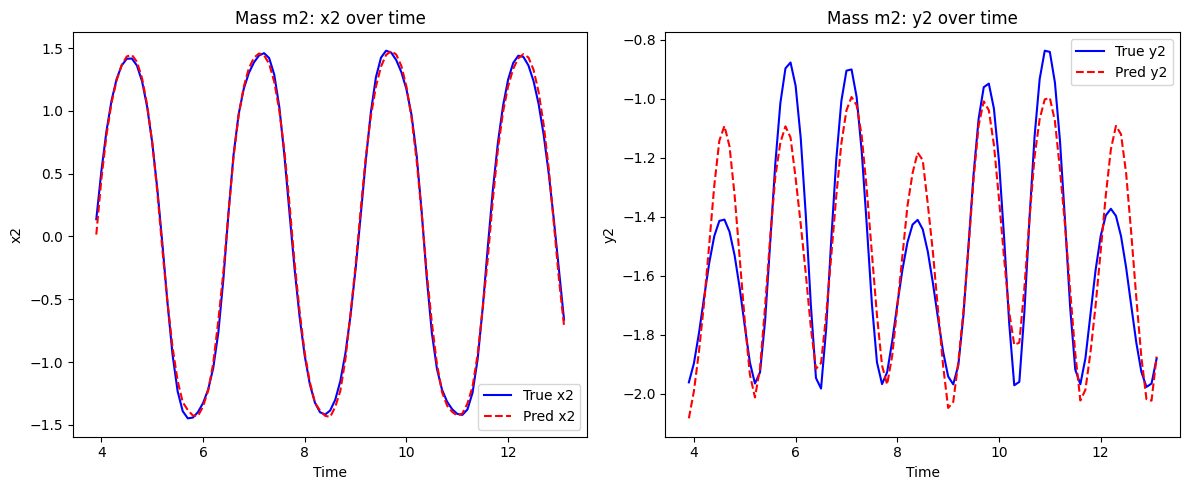

In [187]:
model_m2, history, val_mse, data_m2 = run_experiment_m2(z0, k, pred_ahead)

In [188]:
deltas = [0.02, 0.05]

def plot_pert_pend_m2(deltas, k, pred_ahead, model_m2, t, z0):

    """
    Evaluates the stability of the m2-only model under small initial-angle
    perturbations. Re-solves the ODE, extracts (x2, y2), and compares
    predicted vs. true trajectories.

    Parameters:

    deltas : list of float
        Small angle perturbations for the initial condition's theta1
    k : int
        Window size used to create the (x2, y2) input sequences.
    pred_ahead : int
        How many steps beyond the window to predict.

    Returns:

        Displays plots of x2(t) and y2(t) for each perturbation,
        comparing model predictions against the ODE solution.
    """
    ...



    colors = plt.cm.viridis(np.linspace(0, 1, len(deltas)))

    fig, ax = plt.subplots(1, 2, figsize=(12, 5), sharex=True)

    for i, delta in enumerate(deltas):

        z0_pert = [z0[0] + delta, z0[1], z0[2] + delta, z0[3]]


        ret = solve_ivp(rhs, (0, tmax), z0_pert, t_eval=t, args=(L1, L2, m1, m2, g))
        theta1_pert, w1_pert, theta2_pert, w2_pert = ret.y


        new_x1, new_y1, new_x2, new_y2, new_vx1, new_vy1, new_vx2, new_vy2 = to_cartesian(
            theta1_pert, w1_pert, theta2_pert, w2_pert, L1, L2
        )


        pert_data_m2 = np.column_stack((new_x2, new_y2))

        X_pert, y_pert = create_dataset(pert_data_m2, k, pred_ahead)

        predictions = model_m2.predict(X_pert)

        time_pred = t[k - 1 + pred_ahead : k - 1 + pred_ahead + len(predictions)]

        true_x2 = new_x2[k - 1 + pred_ahead : k - 1 + pred_ahead + len(predictions)]
        true_y2 = new_y2[k - 1 + pred_ahead : k - 1 + pred_ahead + len(predictions)]

        ax[0].plot(time_pred, true_x2, color=colors[i], linestyle='-', linewidth=2,
                   label=f"True, δ={delta}")
        ax[0].plot(time_pred, predictions[:, 0], color='green', linestyle='-',
                   linewidth=1, alpha=0.7,
                   label="Predicted" if i == 0 else None)


        ax[1].plot(time_pred, true_y2, color=colors[i], linestyle='-', linewidth=2,
                   label=f"True, δ={delta}")
        ax[1].plot(time_pred, predictions[:, 1], color='green', linestyle='-',
                   linewidth=1, alpha=0.7,
                   label="Predicted" if i == 0 else None)

    ax[0].set_title("Mass m2: x2 vs. Time")
    ax[0].set_xlabel("Time")
    ax[0].set_ylabel("x2")
    ax[0].legend()

    ax[1].set_title("Mass m2: y2 vs. Time")
    ax[1].set_xlabel("Time")
    ax[1].set_ylabel("y2")
    ax[1].legend()

    plt.tight_layout()
    plt.show()

# **Observations for Mass m_2, delta = [0.02, 0.05] from the pi/4 Initial Condition**

- **Close Overlap in x_2**  
  Even with small changes to the initial angle purple for delta=0.02, yellow for delta=0.05, the predicted x_2 trajectory green stays tightly aligned with both true curves. This suggests the network effectively captures the second mass’s horizontal oscillation across small perturbations.

- **More Variation in y_2**  
  In the right plot, the model’s single predicted curve green typically lies between the two perturbed true signals purple and yellow. Although it follows the main peaks and valleys, we see some amplitude mismatches—common in a slightly chaotic regime when minor angle perturbations shift the system’s vertical motion.

- **Stability for Mild Perturbations**  
  Since delta is small and the initial condition pi/4 is relatively low‐energy, the overall spread between delta=0.02 and delta=0.05 is not very large. The model’s single predicted line remains fairly close to both real trajectories for much of the 50‐second window.

- **Key Takeaway**  
  When focusing solely on x_2,,y_2, the LSTM appears robust to small changes in the initial angle, especially for a simpler initial state like pi/4. The most obvious errors show up in y_2 amplitude and phase, but are still minimal compared to more energetic conditions.


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


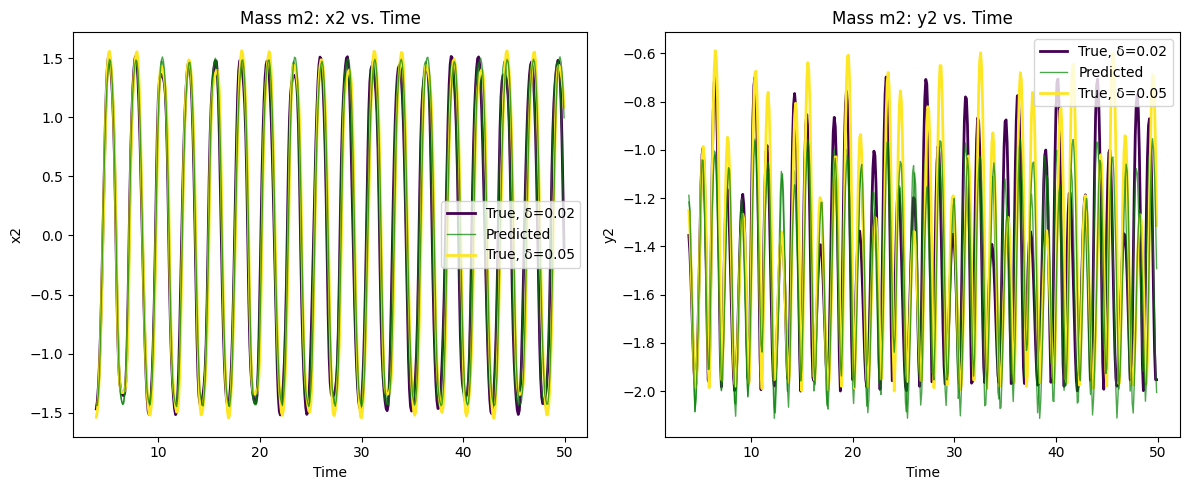

In [189]:
plot_pert_pend_m2(deltas, k, pred_ahead, model_m2, t,z0)

In [190]:
prediction_values = [20, 40, 60, 80, 100]
k = 20

def prediction_err_plot_m2(prediction_values, k, data_m2):

    """
    Shows how validation MSE changes for various prediction horizons
    when training only on (x2, y2). A separate LSTM is trained for each
    'pred_ahead' in prediction_values, then MSE is computed.

    Parameters:

    prediction_values : list of int
        Different timesteps ahead (20, 40, 60, etc.) to predict and test.
    k : int
        Window size used in create_dataset_m2().

    Returns:

    None
        Displays a Matplotlib figure of validation MSE vs. each value
        in prediction_values.
    """

    errors = []

    for pred_ahead in prediction_values:
        model_m2_new = create_model_m2(k)

        X, y = create_dataset_m2(data_m2, k, pred_ahead)

        split_idx = int(0.8 * len(X))
        X_train, y_train = X[:split_idx], y[:split_idx]
        X_val,   y_val   = X[split_idx:], y[split_idx:]

        history = model_m2_new.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=30, batch_size=32, verbose=0)

        val_mse = model_m2_new.evaluate(X_val, y_val, verbose=0)
        errors.append(val_mse)

    plt.figure(figsize=(8, 5))
    plt.plot(prediction_values, errors, marker='o', linestyle='-')
    plt.title("Prediction Error vs. Prediction values")
    plt.xlabel("Future timesteps")
    plt.ylabel("Validation MSE")
    plt.grid()
    plt.show()

# **MSE vs. Prediction Horizon for Mass m_2, with pi/4 Initial Condition**

- **General Fluctuations**  
  The MSE starts around 0.01, dips to about 0.008 at 40 steps, then rises again at 60 steps, dips significantly at 80, and finally peaks near 0.018 at 100 steps. This irregular pattern suggests the model’s training runs and random initializations yield different degrees of success at each horizon.

- **Moderate to High Error Growth**  
  By the 100‐step mark, the MSE is roughly double the lowest point. This growth is understandable for a chaotic system, as longer horizon predictions typically diverge more from the real trajectory.

- **Significance of the Dips**  
  The dip near 40 steps and especially at 80 steps indicates that those training runs converged more effectively, or that the model found patterns in the dataset that better match those forecast intervals.

- **Overall Trend**  
  While one expects a steady upward slope for longer horizons, these experiments highlight how re‐training at each horizon can produce non‐monotonic outcomes. Even then, the net rise at 100 steps shows the difficulty of extended forecasting for a chaotic pendulum, even when focusing solely on x_2, y_2.


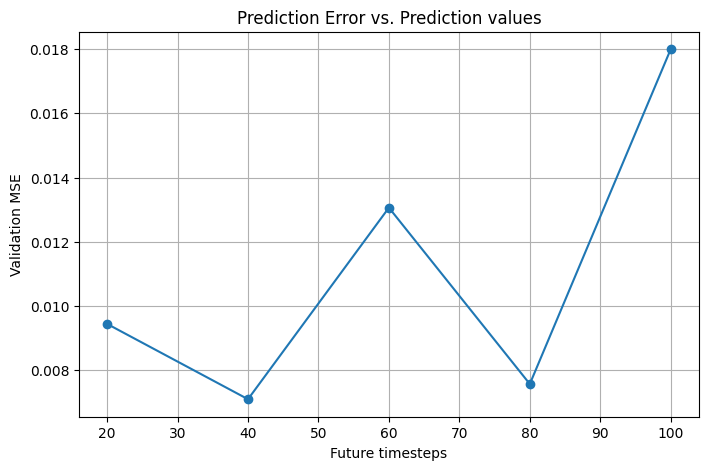

In [191]:
prediction_err_plot_m2(prediction_values, k, data_m2)

# **Observations for Mass m_2 with z_0 = [pi/2, 0, pi/2, 0]**

- **High‐Energy Initial Condition**  
  With both pendulums starting at pi/2, the second mass moves more erratically, generating larger amplitude swings in both x_2 and y_2. Compared to pi/4, the motion is significantly more chaotic.

- **Large Gaps Between True and Predicted**  
  The predicted red dashed lines often lag or lead the real trajectory by a half‐cycle or more. This indicates the model struggles to maintain the correct phase once the system’s chaotic tendencies take hold. In some intervals, the shapes vaguely align, but the timing mismatch remains.

- **Phase and Amplitude Mismatch**  
  The difference is visible in both coordinates. Even though the network captures the overall oscillatory nature, it can’t consistently match peak heights or trough positions in time—a common outcome for chaotic systems when the model sees only a single mass’s data and the initial state is highly energetic.

- **Validation MSE**  
  The reported MSE ~1.28 is notably higher than in the pi/4 or combined‐mass scenarios with lower energy. This reaffirms that learning long‐term chaotic behavior is especially challenging when initial conditions amplify the complexity.

- **Key Takeaway**  
  Focusing on x_2, y_2 alone under a high‐energy initial condition leads to bigger errors and repeated phase drift. While the network still reproduces the rough oscillatory frequency, it diverges more often in amplitude, highlighting the sensitivity of the double pendulum at larger angles.


Epoch 1/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - loss: 0.8799 - val_loss: 0.4784
Epoch 2/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.6920 - val_loss: 0.4762
Epoch 3/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.6617 - val_loss: 0.4771
Epoch 4/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.6294 - val_loss: 0.4771
Epoch 5/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.5905 - val_loss: 0.4865
Epoch 6/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.5608 - val_loss: 0.4981
Epoch 7/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.5386 - val_loss: 0.5119
Epoch 8/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.5169 - val_loss: 0.5299
Epoch 9/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.4951 - val_loss: 0.5525
Epoch 10/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.4762 - val_loss: 0.5825
Epoch 11/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.4549 - val_loss: 0.6169
Epoch 12/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.4

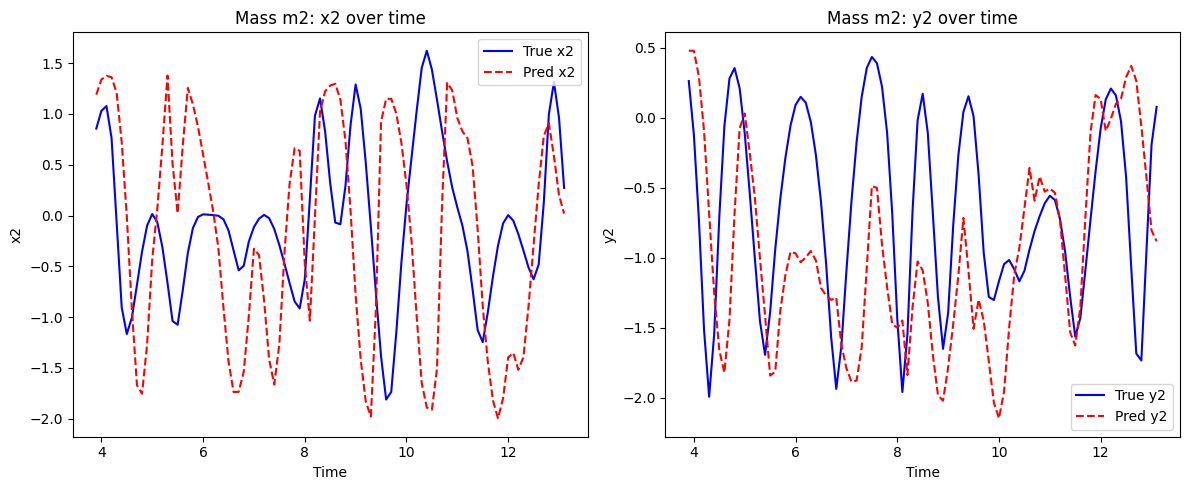

In [192]:
z0 = [np.pi/2, 0, np.pi/2, 0]

model_m2, history, val_mse, data_m2 = run_experiment_m2(z0, k, pred_ahead)

# **Observations for Mass m_2 With Perturbations delta = [0.02, 0.05] Under z_0 = [pi/2, 0, pi/2, 0]**

- **Chaotic Variation in x_2 and y_2**  
  At this higher‐energy initial condition, small changes in angle delta=0.02 or delta=0.05 result in quite different trajectories for both the purple and yellow true lines. The single green Predicted line attempts to approximate them but drifts significantly at various points.

- **Widely Divergent True Paths**  
  Unlike the lower‐energy case, the purple and yellow lines in both plots are often far from each other, underscoring the chaotic sensitivity of the system. The predicted line green frequently falls in between but cannot consistently match both extremes.

- **Phase and Amplitude Mismatches**  
  The predicted curve sometimes aligns with one of the true lines temporarily, then deviates to match the other’s shape. This switching behavior suggests the model can approximate the general frequency but fails to resolve the chaotic details for each perturbed trajectory.

- **Key Takeaway**  
  Training on x_2, y_2 alone for a high‐energy initial condition yields a partially correct oscillatory pattern—yet the actual paths with minor angle offsets diverge faster, making it harder for the single prediction to stay close to either real path. This highlights the challenge of forecasting chaotic systems at higher energies, particularly when the network only sees one mass’s data.


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


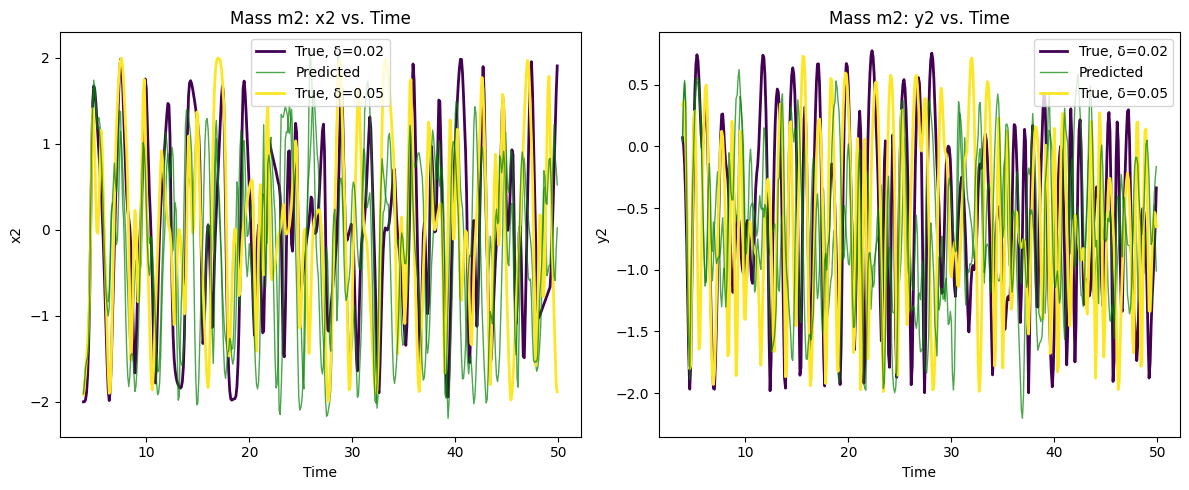

In [193]:
deltas = [0.02, 0.05]

plot_pert_pend_m2(deltas, k, pred_ahead, model_m2, t, z0)

# **MSE vs. Prediction Horizon for m_2 Only, z_0 = [pi/2, 0, pi/2, 0]**

- **Initial High Error at 20 Steps**  
  The curve starts above 1.2 MSE, which is quite large compared to lower‐energy initial conditions. This implies that even short‐term 20 steps predictions for a high‐energy double pendulum can be difficult when training on x_2, y_2 alone.

- **Pronounced Dip at 40 Steps**  
  The MSE unexpectedly falls below 0.7, suggesting that this particular horizon and random training initialization led to a more favorable fit.

- **Subsequent Fluctuations**  
  The error climbs back to around 0.9 at 60 steps, then dips again near 80 steps, and rises to about 1.0 by 100 steps. This non‐monotonic pattern once again reflects the variability in training separate models for each future horizon.

- **Overall Trend**  
  Despite the dips, longer horizons 80–100 steps land near or above 1.0 MSE, reinforcing the notion that chaotic systems become harder to predict as the forecast extends in time. The seemingly contradictory low at 40 steps likely arises from the network’s particular training convergence for that horizon.

- **Key Takeaway**  
  For a high‐energy initial condition, the model’s best run at 40 steps outperforms even the 20‐step horizon. This highlights how chaos plus repeated re‐training can produce surprising anomalies, though in general, errors tend to stay significant across all tested horizons.


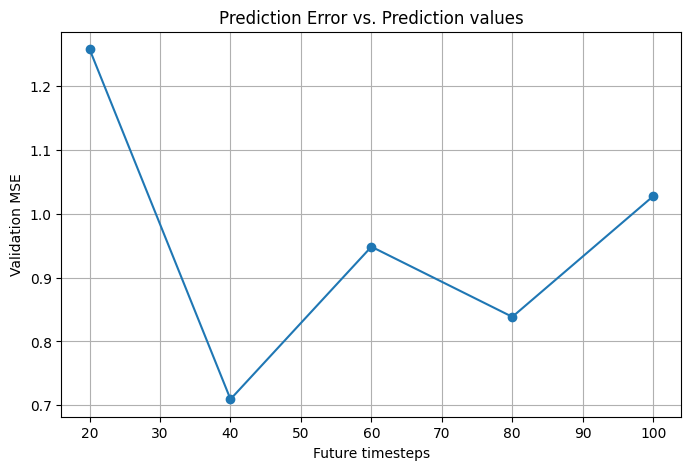

In [194]:
prediction_err_plot_m2(prediction_values, k, data_m2)